<a href="https://colab.research.google.com/github/seun829/DataScience/blob/main/Unit2/SeunLee_U2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unit 2 Project - Detecting the Odds of a Student Without Internet Dropping Out

First we need to import and download all of the required tools.

In [2]:
!pip install preliz
import preliz as pz

import numpy as np
import pymc as pm
import arviz as az
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 5.7 MB/s eta 0:00:00


# Introduction

In this project I create a prediction model to output the probability of a student without internet access choosing to drop out of school (particularly high school and college).

I chose this topic because it is such a fascinating area of study considering how dropping out of school is a very big and uncommon decision for someone to make.



The relevance of this topic is extremely high due to the current situation of a controversy regarding the worth of pursuing a college degree/ completing your high school education. Many people may keep this decision in the back of their head, and it is important to know how often this decision is made nation-wide.

Additionally I am measuring accross students without access to the internet, which is extremely important to have nowadays and is likely a detrimental factor and nuance to whether or not a student decides to drop out.

# Prior


Coming into this, I think that the probability of a student dropping out will be around 5 percent. This guess is based on the data from the National Center for Education Statistics, which claims that for ages 16-24, 5.3% of students chose to drop out (https://nces.ed.gov/fastfacts/display.asp?id=16).

Since this data is from the year 2022 and it claims that the dropout rate has been slowly decreasing, I will assume it is closer to 5 percent in the present rather than 5.3.

However, the point of this project is to take into account that they are without internet access. Considering how rare it is for a student to not have internet access (which is less than the overall drop-out rate) and how important it is for the student to have it, I will assume that students without internet access are around four times more likely (set risk factor r as 4), so 5 * 4 = 20 percent.


In this case, I will assign Alpha to 20 to represent the people dropping out. I will assign Beta to 80 to represent the people who are not dropping out.

<Axes: >

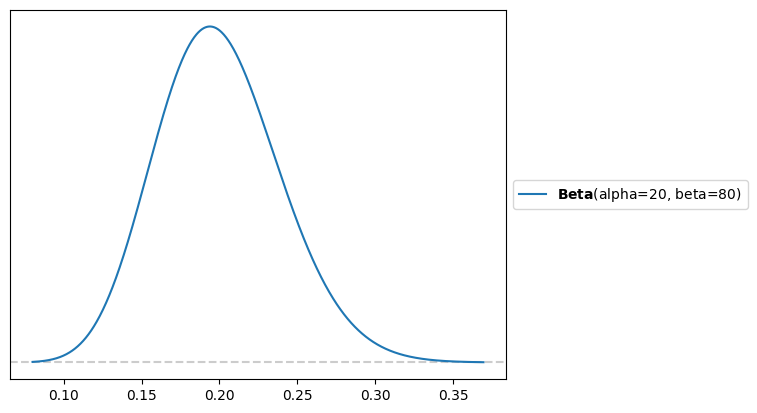

In [3]:
pz.Beta(alpha=20, beta=80).plot_pdf()

In [4]:
dropout_prior = pz.Beta(alpha=20, beta=80)

#Finding the mode of this distribution via a formula
dropout_prior_mode = (dropout_prior.alpha - 1)/(dropout_prior.alpha + dropout_prior.beta - 2)

#Finding the median and the mean of this distribution via a built in function
dropout_prior.mean(), dropout_prior.median(), dropout_prior_mode

(np.float64(0.2), 0.19799480920032295, np.float64(0.19387755102040816))

# Finding Likelihood

Now we are going to load in the dataset. For this project we cannot simply rely on a prior. We must use real world data for our likelihood, which will help us in determining the true probability of a student in high school or college dropping out.

In [5]:
dropout_url = "https://raw.githubusercontent.com/seun829/DataScience/refs/heads/main/Student%20Dropout%20Dataset%20-%20student%20dropout.csv"

dropout = pd.read_csv(dropout_url)

In [6]:
#We want to filter out the ones with internet access
dropout = dropout.query('Internet_Access == "no"')

In [7]:
dropout

,School,Gender,Age,Address,Family_Size,Parental_Status,Mother_Education,Father_Education,Mother_Job,Father_Job,...,Free_Time,Going_Out,Weekend_Alcohol_Consumption,Weekday_Alcohol_Consumption,Health_Status,Number_of_Absences,Grade_1,Grade_2,Final_Grade,Dropped_Out
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,False
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,False
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,1,4,1,1,1,2,10,13,13,False
17,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,1,4,2,13,14,14,False
35,GP,F,15,U,GT3,T,2,3,other,other,...,5,1,1,1,5,4,11,11,11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,MS,F,17,U,GT3,T,2,2,other,at_home,...,4,3,1,1,3,8,10,11,12,False
639,MS,M,19,R,GT3,T,1,1,other,services,...,3,2,1,3,5,0,5,8,0,True
640,MS,M,18,R,GT3,T,4,2,other,other,...,4,3,4,3,3,0,7,7,0,True
641,MS,F,18,R,GT3,T,2,2,at_home,other,...,3,3,1,3,4,0,14,17,15,False


In [8]:
dropout['Dropped_Out']

#Now we find the total amount of times
did_dropout = dropout.query('Dropped_Out == True').shape[0]
not_dropout = dropout.query('Dropped_Out == False').shape[0]



In [9]:
did_dropout

32

In [10]:
not_dropout

119

In [11]:
total = did_dropout + not_dropout
total

151

Now we will use this information to create our likelihood distribution.

<Axes: >

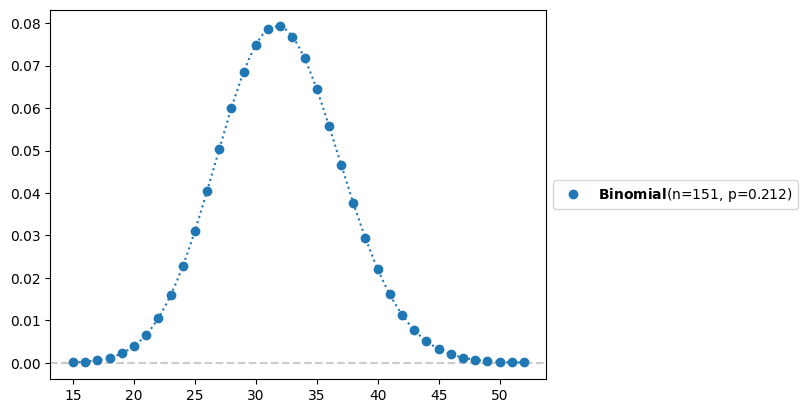

In [12]:
# Likelihood distribution
pz.Binomial(n = 151, p = 32/151).plot_pdf()

# Posterior

Now we will find the posterior by using a pymc model, which I will also visualize.

In [15]:
#the number of dropouts
dropout_makes = np.repeat(1, did_dropout)

#the number of people who didn't dropout
dropout_misses = np.repeat(0, not_dropout)

#combine makes and misses into one array
dropout_data = np.concatenate( [dropout_makes, dropout_misses] )


In [20]:
with pm.Model() as dropout_model:
  #notice how we make alpha and beta floats by using '.'
  θ = pm.Beta('θ' , alpha = 20. , beta = 80.)

  #we define our likelihood
  #Acts as a stand in for the binomial distribution
  #It doesn't have inherent info about number of attempts, but number of attempts
  #is included in the data anyway.
  y = pm.Bernoulli('y', p = θ, observed = dropout_data)

  #We sample from our posterior because we don't actually
  #have a formula for it.
  idata_dropout = pm.sample(progressbar=False)

<Axes: title={'center': 'θ'}>

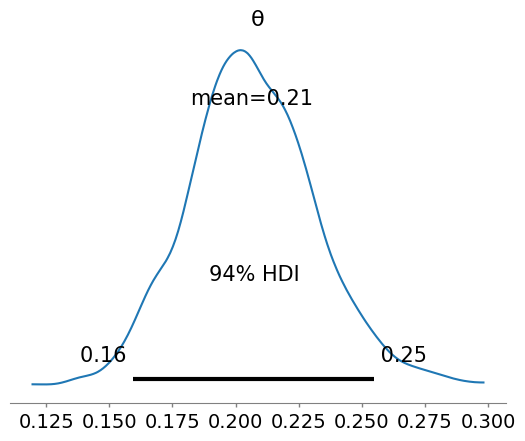

In [21]:
az.plot_posterior(idata_dropout)

# Conclusion

After looking at the results, I realize that my prior prediction was pretty accurate. The mean for the posterior was 0.21 while my prior was 20 percent chance that they dropout. Slightly more people dropped out than I thought.

From this project I learned that using good research and good logic can get you a pretty accurate prior, but the real world data is vital for the goal of getting as accurate as possible.